# CS4447 Final Project - Predicting Real Disasters from Tweets
## Hafez Gharbiah, Tyler Christeson
## data: https://www.kaggle.com/vbmokin/nlp-with-disaster-tweets-cleaning-data

- The problem we're trying to solve is predicting whether a tweet is about a real disaster or not, which can be used to determine if emergency services need to be sent.

- We have a collection of 7,613 tweets. The attributes of the dataset are a unique identifier for each tweet, text of the tweet, where the tweet was sent from, keywords that could be used to identify disasters, and whether or not it is about a real disaster.

- Examples of records:
    - "Heard about # earthquake is different cities, stay safe everyone ." 
    - "Please like and share our new page for our Indoor Trampoline Park Aftershock opening this fall !" 
    - " nowplaying Alfons - Ablaze 2015 on Puls Radio pulsradio" 
    - "Coincidence Or # Curse ? Still # Unresolved Secrets From Past # accident"

- This is a noisy data set because the tweets are not all about disasters, and certain disaster keywords are used in contexts that are not disasters . For example, while "ablaze" is used in several real disaster tweets about ongoing fires, in the above example it is used as a song title. The same is true for many keywords, like "accident" and "aftershock" above.

- Feature engineering can be used in this dataset to:
    - extract years to see if we're tweeting about events that aren't current
    - extract news network name to determine if the accident is being reported on or not
    - topic modeling to extract relevant topics as features

## Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
import string
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
import sklearn

from wordcloud import WordCloud

from joblib import dump, load

# from sklearn.naive_bayes import GaussianNB
# from sklearn.metrics import confusion_matrix
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/christesont/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Loading Data and Duplicating original text

In [2]:
traindf = pd.read_csv('train_data_cleaning.csv',index_col=0)

traindf['original_tweet']=traindf.text
original_text = traindf.original_tweet
original_text = [nltk.word_tokenize(i) for i in original_text]
traindf['original_tweet_length'] = [len(w) for w in original_text]
traindf.sample(20)

,keyword,location,text,target,original_tweet,original_tweet_length
id,,,,,,
8100,rescued,watford,' Trust us to get rescued by the dopey ones !...,0,' Trust us to get rescued by the dopey ones !...,24
10414,whirlwind,"Nairobi, Kenya",Whirlwind that has lasted for more than an hou...,1,Whirlwind that has lasted for more than an hou...,21
3054,deaths,NaN,Bigamist and his first wife are charged in the...,0,Bigamist and his first wife are charged in the...,26
4630,emergency%20services,"Whippany, NJ",Air Group is here to the rescue ! We have 24 ...,0,Air Group is here to the rescue ! We have 24 ...,22
8855,smoke,NaN,I want to smoke ?,0,I want to smoke ?,5
5790,hail,NaN,# np Avenged Sevenfold - Hail To The King,0,# np Avenged Sevenfold - Hail To The King,9
6273,hijacking,between ideas & 3-5pm AEST,to whomever is hijacking my wifi hotspot . I ...,0,to whomever is hijacking my wifi hotspot . I ...,30
9311,survive,"???????, Texas",DO NOT MAKE FUN OF THEM FOR TRYING\nTO SURVIVE...,0,DO NOT MAKE FUN OF THEM FOR TRYING\nTO SURVIVE...,16
10394,whirlwind,Thailand,Weather forecast for Thailand A Whirlwind is ...,1,Weather forecast for Thailand A Whirlwind is ...,11


## EDA on Tweet Location

Proportion of tweets with no location or a unique location: 0.7028766583475634


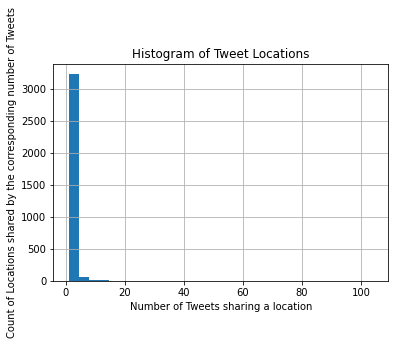

In [3]:
%matplotlib inline
fig, ax = plt.subplots()
ax= traindf.location.value_counts().hist(bins=30)
ax.set_title('Histogram of Tweet Locations')
ax.set_xlabel('Number of Tweets sharing a location')
ax.set_ylabel('Count of Locations shared by the corresponding number of Tweets')

traindf.location.value_counts().nunique()
traindf.location.isnull().sum()
print(f'Proportion of tweets with no location or a unique location: {(traindf.location.isnull().sum()+ traindf.location.value_counts()[traindf.location.value_counts()==1].sum() )/ len(traindf)}')

## Cleaning Data: tokenize, remove stop words, lemmatize

In [4]:
# Quality of cleaning (6 points, 2 points each)
### Data cleaning and type conversion activity. Please share anything unusual you faced during this activity.
### What did you do about missing values and why? Handling missing values properly is very important.
### New feature/attribute creation and data summary statistics and interpretation. 
train_text = traindf.text
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('u')
stopwords.append('rt')
stopwords = set(stopwords + list(string.punctuation))
train_text = [nltk.word_tokenize(i) for i in train_text]

train_text = [[w.lower() for w in train_text[i] if w.lower() not in stopwords] for i in range(len(train_text))]

wnetl = WordNetLemmatizer()

def nltk_tag_pos(tag):   
    #adapted from https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
    if tag[0]=='J':
        return wordnet.ADJ
    elif tag[0]=='V':
        return wordnet.VERB
    elif tag[0]=='N':
        return wordnet.NOUN
    elif tag[0]=='R':
        return wordnet.ADV
    else:          
        return wordnet.NOUN #noun is default lemmatize POS
    
train_text_POS = [nltk.pos_tag(i) for i in train_text]    
train_text = [[wnetl.lemmatize(i[0],nltk_tag_pos(i[1]))  if i[0] != 'us' else i[0] for i in j] for j in train_text_POS]
traindf['cleaned_tweet_length'] = [len(w) for w in train_text]
train_text = [' '.join(train_text[i]) for i in range(len(train_text))]

traindf.text = train_text
traindf['tweet_length_difference'] = traindf.original_tweet_length - traindf.cleaned_tweet_length

## Troubles with cleaning the text:
1. Lemmatizing internet slang, abbreviations, and punctuation resulted in interesting and sometimes incorrect results
    1. Specifically, lemmatizing the word 'us' or abbreviation 'US' led to the short 'u' which was incorrect and threw off analyses

## EDA on Tweet Length

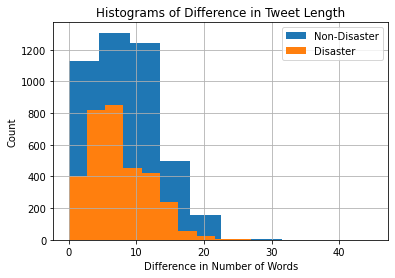

In [5]:
%matplotlib inline
fig, ax = plt.subplots()
ax= traindf[traindf.target==0].tweet_length_difference.hist()
ax = traindf[traindf.target==1].tweet_length_difference.hist()
ax.set_title('Histograms of Difference in Tweet Length')
ax.set_xlabel('Difference in Number of Words')
ax.set_ylabel('Count')
ax.legend(['Non-Disaster','Disaster'])


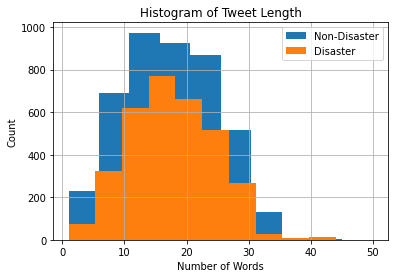

In [6]:
# g = sns.catplot(x="target",y="tweet_length",data=traindf)
%matplotlib inline

fig, ax = plt.subplots()
ax = traindf.original_tweet_length[traindf.target==0].hist()
ax = traindf.original_tweet_length[traindf.target==1].hist()
ax.set_title('Histogram of Tweet Length')
ax.set_xlabel('Number of Words')
ax.set_ylabel('Count')
ax.legend(['Non-Disaster','Disaster'])

## Most common words before/after stop word removal

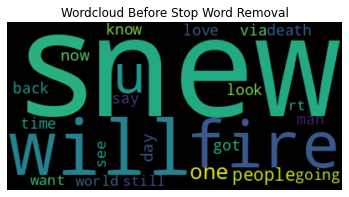

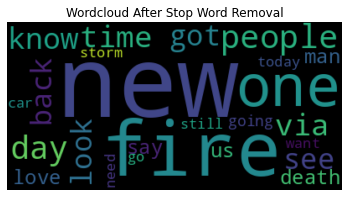

In [7]:
text = ' '.join(traindf.original_tweet.str.split(' ').sum()).lower()
# word cloud before stop word removal
wordcloud = WordCloud(max_words=25).generate(text)

import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud Before Stop Word Removal")
plt.show()

# word cloud after stop word removal
word_tokens = nltk.word_tokenize(text)

word_tokens = [word for word in word_tokens if word not in stopwords]
text = ' '.join(word_tokens)
wordcloud = WordCloud(max_words=25).generate(text)

import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud After Stop Word Removal")
plt.show()


## Bigrams before and after cleaning

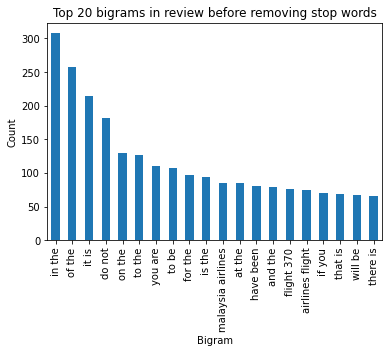

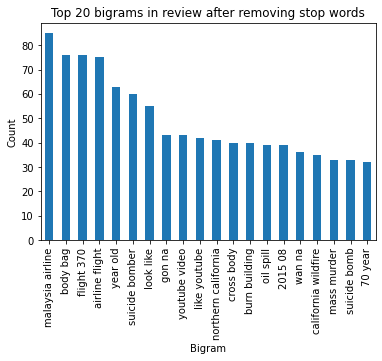

In [8]:
corpus = text
# source for bigram:
# https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
def get_top_n_bigram(corpus, n=None,gram=2):
    vec = CountVectorizer(ngram_range=(gram, gram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(traindf['original_tweet'], 20)
gramdf = pd.DataFrame(common_words, columns = ['original_tweet' , 'count'])
fig, ax = plt.subplots()
ax = gramdf.groupby('original_tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',xlabel='Bigram', ylabel='Count', title='Top 20 bigrams in review before removing stop words')

common_words = get_top_n_bigram(traindf['text'], 20)
gramdf = pd.DataFrame(common_words, columns = ['text' , 'count'])
fig, ax = plt.subplots()
ax =gramdf.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',xlabel='Bigram', ylabel='Count', title='Top 20 bigrams in review after removing stop words')

## Trigrams before and after cleaning

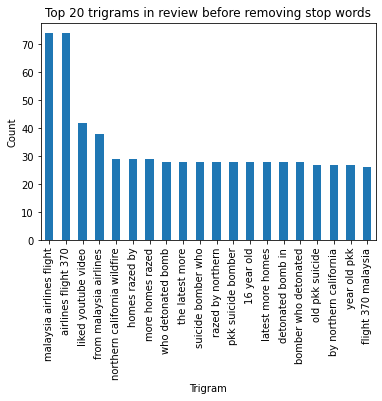

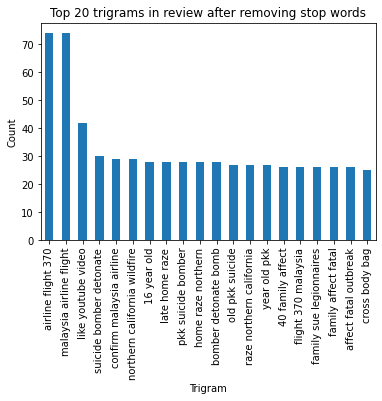

In [9]:
common_words = get_top_n_bigram(traindf['original_tweet'], 20,gram=3)
gramdf = pd.DataFrame(common_words, columns = ['original_tweet' , 'count'])
fig, ax = plt.subplots()
ax =gramdf.groupby('original_tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',xlabel='Trigram', ylabel='Count', title='Top 20 trigrams in review before removing stop words')

common_words = get_top_n_bigram(traindf['text'], 20,gram=3)
gramdf = pd.DataFrame(common_words, columns = ['text' , 'count'])
fig, ax = plt.subplots()
ax = gramdf.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',xlabel='Trigram', ylabel='Count', title='Top 20 trigrams in review after removing stop words')

## Fitting Models and Evaluating Precision

In [10]:
def plot_confusion_matrix(confusionMatrix):
    ax = plt.subplot()
    sns.heatmap(confusionMatrix, annot=True, fmt='g', ax=ax, cmap='Greens')
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Non-Emergency', 'Emergency'])
    ax.yaxis.set_ticklabels(['Non-Emergency', 'Emergency'])
    plt.show()

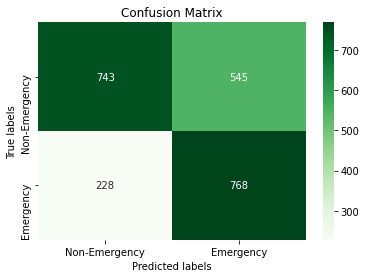

Model precision is: 0.584920030464585


In [11]:
#bag of words model
cv = CountVectorizer(ngram_range=(1,3),max_features=50000)
x= cv.fit_transform(train_text).toarray()
y = traindf.target.values

#70:30 train-test split
xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(x,y,test_size=0.3,random_state=1234)

import sklearn.naive_bayes


classifier = sklearn.naive_bayes.GaussianNB()
classifier.fit(xtrain,ytrain)

ypred = classifier.predict(xtest)
ypred

confusionMatrix = sklearn.metrics.confusion_matrix(ytest,ypred)


plot_confusion_matrix(confusionMatrix)
tn, fp, fn, tp = confusionMatrix.ravel()
accuracy = (tp+tn)/(sum(sum(confusionMatrix)))
precision = tp / (tp+fp)
modeldf = pd.DataFrame()
models = ['Gaussian Naive Bayes']
precisions = [precision]
print(f'Model precision is: {precision}')

In [12]:
xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(traindf.text, traindf.target, test_size=0.3, random_state=1234)

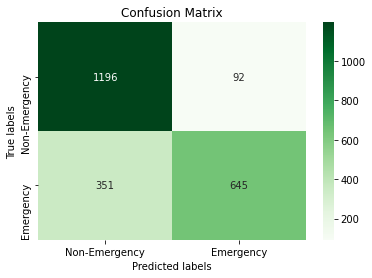

Model precision is: 0.8751696065128901


In [13]:
from sklearn.naive_bayes import MultinomialNB

nb = Pipeline([('vect', CountVectorizer(ngram_range=(1,3),max_features=50000)),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(xtrain, ytrain)
            
ypred = nb.predict(xtest)

confusionMatrix = sklearn.metrics.confusion_matrix(ytest,ypred)
plot_confusion_matrix(confusionMatrix)
tn, fp, fn, tp = confusionMatrix.ravel()
accuracy = (tp+tn)/(sum(sum(confusionMatrix)))
precision = tp / (tp+fp)
models.append('Multinomial Naive Bayes')
precisions.append(precision)
print(f'Model precision is: {precision}')

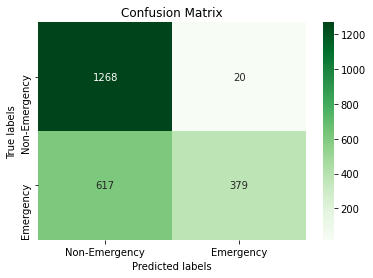

Model precision is: 0.949874686716792


['SGDclassifiermodel']

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

sgd = Pipeline([('vect', CountVectorizer(ngram_range=(1,3),max_features=50000)),
                ('tfidf', TfidfTransformer()),
                ('feature_selection', SelectFromModel(SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),

               ])
sgd.fit(xtrain, ytrain)

ypred = sgd.predict(xtest)

confusionMatrix = sklearn.metrics.confusion_matrix(ytest,ypred)
# from sklearn.metrics import plot_confusion_matrix
# sklearn.metrics.plot_confusion_matrix(sgd, X=xtest, y_true=ytest)
plot_confusion_matrix(confusionMatrix)
tn, fp, fn, tp = confusionMatrix.ravel()
accuracy = (tp+tn)/(sum(sum(confusionMatrix)))
precision = tp / (tp+fp)
models.append('SGD Classifier')
precisions.append(precision)
print(f'Model precision is: {precision}')

dump(sgd, 'SGDclassifiermodel') #we saved the model

/mnt/c/users/chris/desktop/atomprojects/cs4447/dst1_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


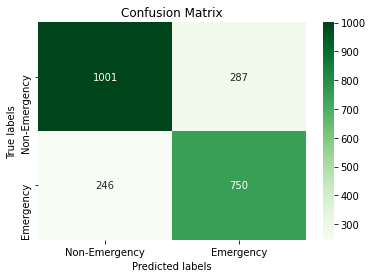

Model precision is: 0.7232401157184185


In [15]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1,3),max_features=50000)),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(xtrain, ytrain)

ypred = logreg.predict(xtest)

confusionMatrix = sklearn.metrics.confusion_matrix(ytest,ypred)


plot_confusion_matrix(confusionMatrix)
tn, fp, fn, tp = confusionMatrix.ravel()
accuracy = (tp+tn)/(sum(sum(confusionMatrix)))
precision = tp / (tp+fp)
models.append('Logistic Regression')
precisions.append(precision)
print(f'Model precision is: {precision}')

# Comparison of Model Precision
## SGD Classifier was chosen for 94.9% precision


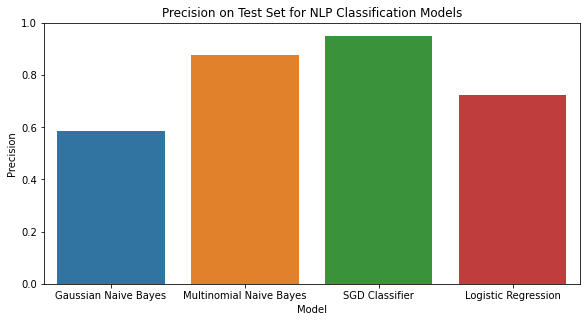

In [16]:
modeldf['model']=models
modeldf['precision']=precisions
modeldf
plt.figure(figsize=(9.6,4.8))
g= sns.barplot(x='model', y='precision',data=modeldf)
# g.set_xticklabels(rotation=30,labels=modeldf.model)
g.set(xlabel='Model', ylabel='Precision')
g.set_title('Precision on Test Set for NLP Classification Models')
g.set_ylim(0,1)
# for index, row in modeldf.iterrows():
#     g.text(row.model,row.precision, round(row.precision,2), color='black', ha="center")
plt.show()

# Interpreting Top Model Features

In [17]:
print(len(sgd.steps[0][1].get_feature_names()))
feature_coef = dict(zip(sgd.steps[0][1].get_feature_names(), sgd.steps[3][1].coef_[0]))
feature_coef


50000


{'00': 0.4001402884969616,
 '00 11': 0.08476842134196236,
 '00 11 16': 0.2347197423036049,
 '00 11 utc': 0.06408357277773535,
 '00 18': 0.44479773524208316,
 '00 18 00': 0.14181502589257755,
 '00 25': 0.07027380998802032,
 '00 25 updated': 0.08169385741962949,
 '00 52': 0.07027380998802032,
 '00 52 25': 0.07027380998802032,
 '00 bestseller': 0.1288569836206228,
 '00 current': 0.07027380998802032,
 '00 current condition': 0.06758272357130614,
 '00 earthquake': 0.07985828962384184,
 '00 ep': 0.2776818745225594,
 '00 ep csismica': 0.19565376723861663,
 '00 ep sm': 0.07027380998802032,
 '00 epicenter': 0.1288569836206228,
 '00 epicenter sm': 0.08169385741962949,
 '00 hiroshima': 0.4296685764378161,
 '00 nnw': 0.1019454003584916,
 '00 nnw hana': 0.1515634593951063,
 '00 pm': 0.07027380998802032,
 '00 pm 00': 0.28816045916001914,
 '00 pm 06': 0.12847118756348516,
 '00 pm cdt': 0.07027380998802032,
 '00 pm edt': 0.09905585390241439,
 '00 pm rogue': 0.0795819217718027,
 '00 pm wednesday': 0.54

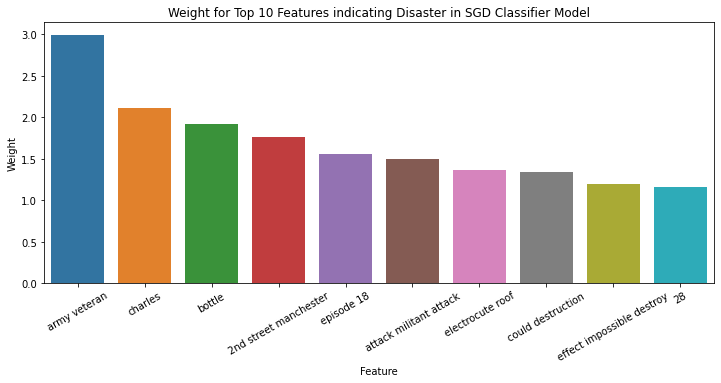

In [18]:
top_emergency_coef_df = pd.DataFrame()
feature = sorted(feature_coef, key=feature_coef.get, reverse=True)[:10]
weight = [feature_coef[i] for i in feature]
top_emergency_coef_df['feature']=feature
top_emergency_coef_df['weight']=weight

plt.figure(figsize=(12,4.8))
g= sns.barplot(x='feature', y='weight',data=top_emergency_coef_df)
g.set(ylabel='Weight', xlabel='Feature')
g.set_title('Weight for Top 10 Features indicating Disaster in SGD Classifier Model')
g.set_xticklabels(rotation=30,labels=top_emergency_coef_df.feature)
plt.show()



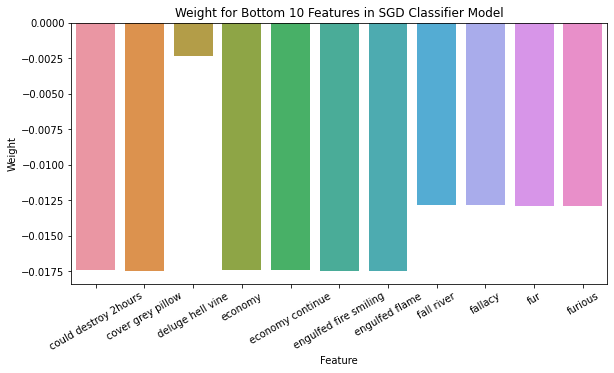

In [19]:
bottom_coef_df = pd.DataFrame()

closest_weights_to_zero = {k:v for k, v in feature_coef.items() if abs(v) <= 0.019}

bottom_coef_df['feature'] = closest_weights_to_zero.keys()
bottom_coef_df['weight'] = closest_weights_to_zero.values()

plt.figure(figsize=(9.6,4.8))
g = sns.barplot(x='feature', y='weight',data=bottom_coef_df)
g.set(ylabel='Weight', xlabel='Feature')
g.set_title('Weight for Bottom 10 Features in SGD Classifier Model')
plt.xticks(rotation=30)
plt.show()

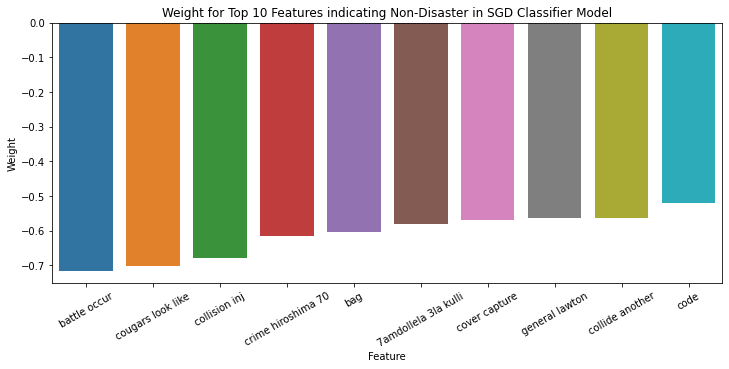

In [20]:
top_nonemergency_coef_df = pd.DataFrame()
feature = sorted(feature_coef, key=feature_coef.get, reverse=False)[:10]
weight = [feature_coef[i] for i in feature]
top_nonemergency_coef_df['feature']=feature
top_nonemergency_coef_df['weight']=weight

plt.figure(figsize=(12,4.8))
g= sns.barplot(x='feature', y='weight',data=top_nonemergency_coef_df)
g.set(ylabel='Weight', xlabel='Feature')
g.set_title('Weight for Top 10 Features indicating Non-Disaster in SGD Classifier Model')
g.set_xticklabels(rotation=30,labels=top_nonemergency_coef_df.feature)
plt.show()